In [2]:
import torch
import torch.nn as nn

In [3]:
device='cuda:1'

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.w1 = nn.Linear(2, 1024)
        self.a1 = nn.Tanh()
        self.w2 = nn.Linear(1024, 1024)
        self.a2 = nn.Tanh()
        self.w3 = nn.Linear(1024, 1024)
        self.a3 = nn.Tanh()
        self.w4 = nn.Linear(1024, 1)

    def forward(self, x, t):
        u = torch.cat((x, t), dim=1)
        u = self.w1(u)
        u = self.a1(u)

        u = self.w2(u)
        u = self.a2(u)
        u = self.w3(u)
        u = self.a3(u)
        u = self.w4(u)
        return u

In [13]:
net = Net()
net.to(device)

Net(
  (w1): Linear(in_features=2, out_features=1024, bias=True)
  (a1): Tanh()
  (w2): Linear(in_features=1024, out_features=1024, bias=True)
  (a2): Tanh()
  (w3): Linear(in_features=1024, out_features=1024, bias=True)
  (a3): Tanh()
  (w4): Linear(in_features=1024, out_features=1, bias=True)
)

In [14]:
def solution(x, t):
    return torch.exp(-0.4 * torch.pi**2 * t) * torch.sin(torch.pi * x)


def heat(iter_num, model, x, t):
    u = model(x, t)
    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True, retain_graph=True)[0]
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True, retain_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True, retain_graph=True)[0]
    return u_t - 0.4 * u_xx

In [15]:
optim = torch.optim.Adam(net.parameters(), lr=1e-3, weight_decay=0.0)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, 'min', factor=0.5, patience=5)

In [16]:
iters = 20000
batch_size = 256

In [17]:
for iter in range(iters):
    x = torch.rand(batch_size, 1, requires_grad=True) # x in [0, 1)
    t = torch.rand(batch_size, 1, requires_grad=True) # t in [0, 1)

    x, t = x.to(device), t.to(device)

    def closure():
        optim.zero_grad()
        loss = heat(iter+1, net, x, t) ** 2 + 1.0 * (net(torch.zeros_like(x), t) ** 2 + net(torch.ones_like(x), t) ** 2 + (net(x, torch.zeros_like(t)) - torch.sin(torch.pi * x)) ** 2)
        loss = loss.sum(0)
        loss.backward()
        return loss

    loss = optim.step(closure)

    iter_num = iter + 1
    if iter_num % 1000 == 0:
        print(f"[{iter_num}/{iters}] train loss: {loss.item():<.10f}")
        scheduler.step(loss.item())

[1000/20000] train loss: 52.1904258728
[2000/20000] train loss: 33.4939537048
[3000/20000] train loss: 26.9627285004
[4000/20000] train loss: 21.6811332703
[5000/20000] train loss: 16.7468280792
[6000/20000] train loss: 13.9201183319
[7000/20000] train loss: 8.7227182388
[8000/20000] train loss: 6.2095065117
[9000/20000] train loss: 4.5607357025
[10000/20000] train loss: 3.5216221809
[11000/20000] train loss: 2.8277316093
[12000/20000] train loss: 1.9720488787
[13000/20000] train loss: 1.5050081015
[14000/20000] train loss: 1.0933260918
[15000/20000] train loss: 0.9077367783
[16000/20000] train loss: 0.5917829275
[17000/20000] train loss: 0.5369254351
[18000/20000] train loss: 0.3816848993
[19000/20000] train loss: 0.3159357011
[20000/20000] train loss: 0.2377998531


In [18]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

net.eval()

def plot_solution_preds(t, points=1000):
    x = torch.Tensor(np.linspace(0, 1, points))
    y = solution(x, torch.full(x.shape, fill_value=t)).numpy()

    x_n = x.unsqueeze(1)
    x_n = x_n.to(device)
    y_n = torch.full(x_n.shape, fill_value=t)
    y_n = y_n.to(device)
    with torch.no_grad():
        pred = net(x_n, y_n).squeeze().cpu().detach().numpy()

    plt.figure(figsize=(5, 5))
    plt.plot(x, y, label='GT')
    plt.plot(x, pred, label='predicted')
    plt.title(f"T = {t:.3f}")
    plt.xlabel("x")
    plt.ylabel(f"u(x, t={t:.3f})")
    plt.ylim([0.0, 1.0])
    plt.xlim([0.0, 1.0])
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"burgers_examples/img_{int(t*1000)}.png", bbox_inches='tight')
    plt.show()
    plt.close()

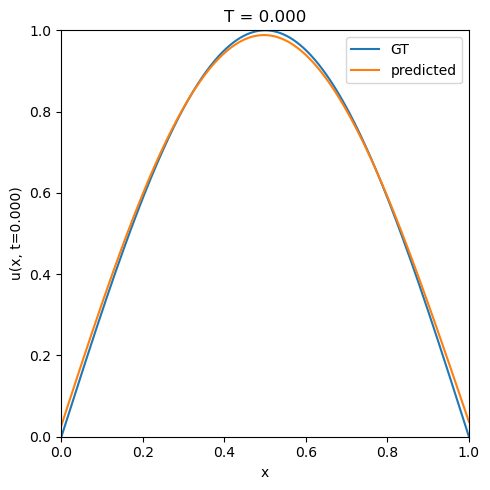

In [19]:
plot_solution_preds(0.)

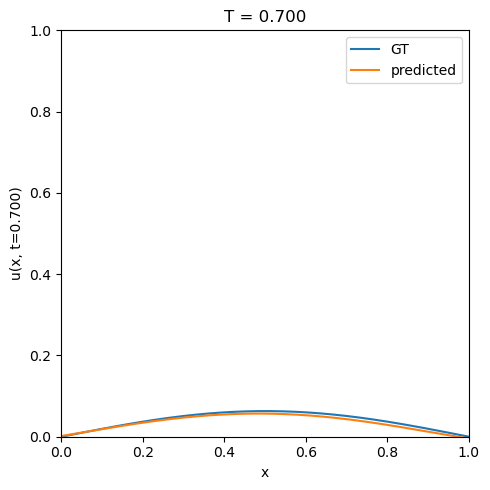

In [20]:
plot_solution_preds(0.7)

In [48]:
# torch.save(net.state_dict(), "best_mlp_heat_Adam.ckpt")

In [51]:
from tqdm import tqdm

for t in tqdm(range(1000)):
    plot_solution_preds(t/1000.)

100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:33<00:00,  6.52it/s]


In [52]:
from pathlib import Path
import imageio

In [53]:
img_directory = Path("/home/n.lokshin/pinn/burgers_examples")
imgs = [x for x in img_directory.iterdir() if ".png" in str(x)]
imgs = sorted(imgs, key=lambda x: int(str(x).split(".png")[0].split("img_")[-1]))
images = []
for img in imgs:
    if ".png" in str(img):
        images.append(imageio.imread(str(img)))
imageio.mimsave('movie.gif', images)

/tmp/ipykernel_15814/1720021472.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(str(img)))


![SegmentLocal](movie.gif "RESULT")